In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install kaggle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os

os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content/


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
... resuming from 762314752 bytes (4820599759 bytes left) ...
100% 5.20G/5.20G [02:30<00:00, 20.7MB/s]
100% 5.20G/5.20G [02:30<00:00, 32.0MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/skin-cancer-mnist-ham10000.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ham10000')

In [ ]:
import os

dataset_dir = '/content/ham10000'

dataset_contents = os.listdir(dataset_dir)

print(dataset_contents)

['hmnist_8_8_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_28_28_L.csv', 'HAM10000_images_part_1', 'ham10000_images_part_2', 'hmnist_8_8_RGB.csv', 'ham10000_images_part_1', 'HAM10000_metadata.csv', 'HAM10000_images_part_2']


In [ ]:
import os

dataset_dir = '/content/ham10000'
images_part_1_dir = os.path.join(dataset_dir, 'HAM10000_images_part_1')
images_part_1_files = os.listdir(images_part_1_dir)
num_images_part_1 = len(images_part_1_files)
print(f"Number of images in HAM10000_images_part_1: {num_images_part_1}")

images_part_2_dir = os.path.join(dataset_dir, 'HAM10000_images_part_2')
images_part_2_files = os.listdir(images_part_2_dir)
num_images_part_2 = len(images_part_2_files)
print(f"Number of images in HAM10000_images_part_2: {num_images_part_2}")


Number of images in HAM10000_images_part_1: 5000
Number of images in HAM10000_images_part_2: 5015


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision.all import *
from fastai.metrics import *
import pandas as pd
from pathlib import Path


In [ ]:
csv_path = "/content/ham10000/HAM10000_metadata.csv"
skin_df = pd.read_csv(csv_path)
skin_df.sort_values(by="image_id")

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


In [ ]:
path = Path('../content/ham10000')
Path.BASE_PATH = path
path.ls()

(#9) [Path('hmnist_8_8_L.csv'),Path('hmnist_28_28_RGB.csv'),Path('hmnist_28_28_L.csv'),Path('HAM10000_images_part_1'),Path('ham10000_images_part_2'),Path('hmnist_8_8_RGB.csv'),Path('ham10000_images_part_1'),Path('HAM10000_metadata.csv'),Path('HAM10000_images_part_2')]

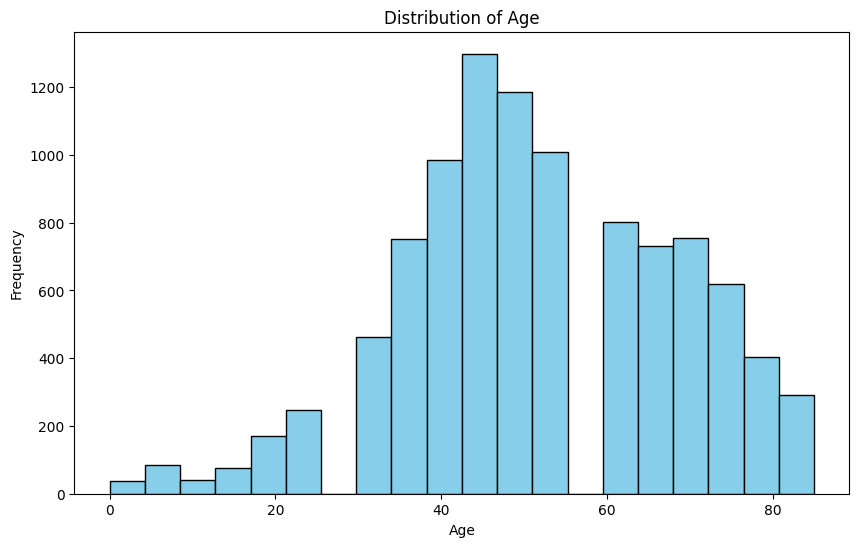

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(skin_df['age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

In [ ]:
sex_counts = skin_df['sex'].value_counts(normalize=True) * 100
print("Distribution of Sex (Percentage):")
print(sex_counts)

Distribution of Sex (Percentage):
sex
male       53.979031
female     45.451822
unknown     0.569146
Name: proportion, dtype: float64


In [ ]:
localization_counts = skin_df['localization'].value_counts(normalize=True) * 100
print("Distribution of Localization (Percentage):")
print(localization_counts)


Distribution of Localization (Percentage):
localization
back               21.887169
lower extremity    20.738892
trunk              14.018972
upper extremity    11.163255
abdomen            10.204693
face                7.438842
chest               4.063904
foot                3.185222
unknown             2.336495
neck                1.677484
scalp               1.278083
hand                0.898652
ear                 0.559161
genital             0.479281
acral               0.069895
Name: proportion, dtype: float64


In [ ]:
short_to_full_name_dict = {
    "akiec" : "Bowen's disease", # very early form of skin cancer
    "bcc" : "basal cell carcinoma" , # basal-cell cancer or white skin cancer
    "bkl" : "benign keratosis-like lesions", # non-cancerous skin tumour
    "df" : "dermatofibroma", # non-cancerous rounded bumps
    "mel" : "melanoma", # black skin cancer
    "nv" : "melanocytic nevi", # mole non-cancerous
    "vasc" : "vascular lesions", # skin condition
}

In [ ]:
img_to_class_dict = skin_df.loc[:, ["image_id", "dx"]]
img_to_class_dict = img_to_class_dict.to_dict('list')
img_to_class_dict = {img_id : short_to_full_name_dict[disease] for img_id,disease in zip(img_to_class_dict['image_id'], img_to_class_dict['dx']) }
[x for x in img_to_class_dict.items()][:5]

[('ISIC_0027419', 'benign keratosis-like lesions'),
 ('ISIC_0025030', 'benign keratosis-like lesions'),
 ('ISIC_0026769', 'benign keratosis-like lesions'),
 ('ISIC_0025661', 'benign keratosis-like lesions'),
 ('ISIC_0031633', 'benign keratosis-like lesions')]

In [ ]:
disease_counts = Counter(img_to_class_dict.values())

total_samples = len(img_to_class_dict)
percentage_distribution = {short_to_full_name_dict.get(key.lower(), key.lower()): (count / total_samples) * 100 for key, count in disease_counts.items()}

df = pd.DataFrame(list(percentage_distribution.items()), columns=['Disease Type', 'Percentage (%)'])
df = df.sort_values(by='Percentage (%)', ascending=False)

print("Percentage-wise Distribution of Disease Types:")
print(df.to_string(index=False))

Percentage-wise Distribution of Disease Types:
                 Disease Type  Percentage (%)
             melanocytic nevi       66.949576
                     melanoma       11.113330
benign keratosis-like lesions       10.973540
         basal cell carcinoma        5.132302
              bowen's disease        3.265102
             vascular lesions        1.417873
               dermatofibroma        1.148278


In [ ]:
def get_label_from_dict(path):
    return img_to_class_dict[path.stem]

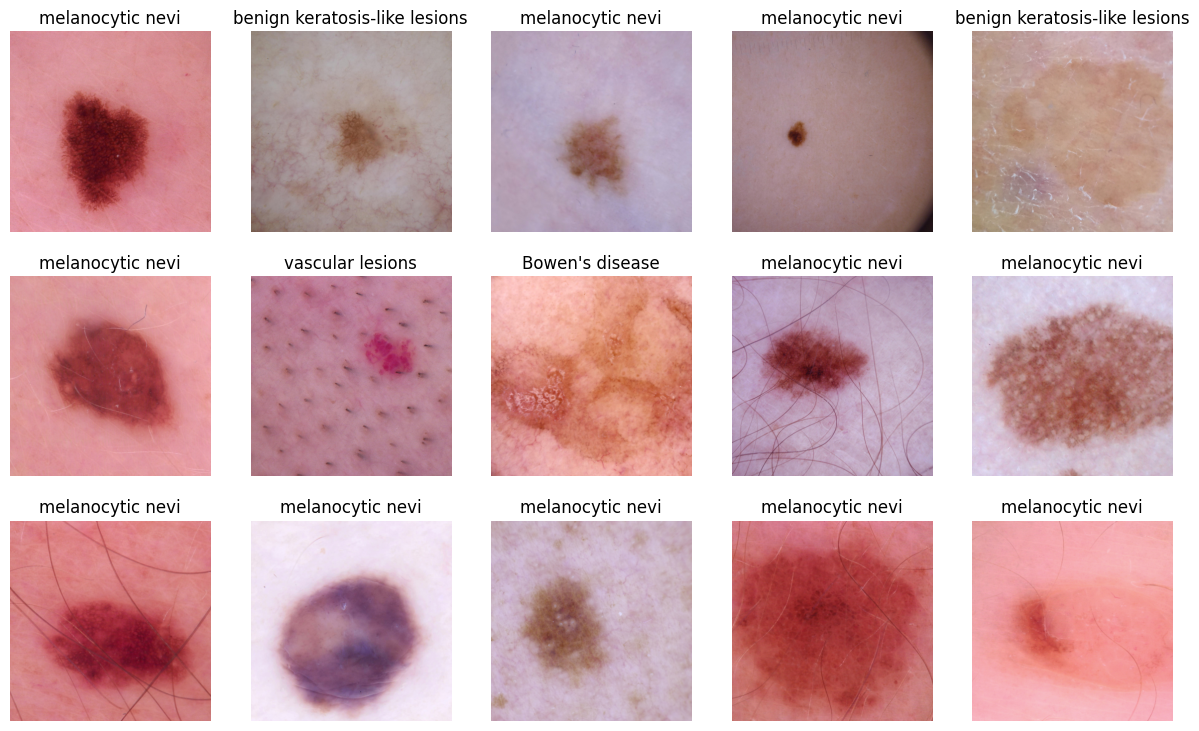

In [ ]:
dblock = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = get_label_from_dict,
    item_tfms=[Resize(448), DihedralItem()],
    batch_tfms=RandomResizedCrop(size=224, min_scale=0.75, max_scale=1.0))

img_path = "/content/ham10000"
dls = dblock.dataloaders(img_path, bs=64)
dls.show_batch(max_n=15)

In [ ]:
print(dls.vocab)
len(dls.train_ds), len(dls.valid_ds)

["Bowen's disease", 'basal cell carcinoma', 'benign keratosis-like lesions', 'dermatofibroma', 'melanocytic nevi', 'melanoma', 'vascular lesions']


(16024, 4006)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy, opt_func=ranger)
learn.fine_tune(epochs=30, freeze_epochs=3, base_lr=0.005, cbs=MixUp(0.5))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.941429,1.002774,0.704194,05:17
1,1.037516,0.650206,0.760609,05:13
2,0.865493,0.583510,0.783575,05:11


epoch,train_loss,valid_loss,accuracy,time
0,0.738498,0.483268,0.825262,05:20
1,0.694723,0.419525,0.855467,05:15
2,0.644342,0.375778,0.863455,05:13
3,0.633822,0.347883,0.880929,05:17
4,0.599305,0.359785,0.866450,05:10
5,0.588519,0.318342,0.885671,05:15
6,0.586069,0.343391,0.874189,05:13
7,0.564787,0.304419,0.890664,05:19
8,0.560160,0.257714,0.916375,05:12
9,0.541358,0.275815,0.910135,05:09
